# Træning af et convolutional network.
Systemet bruger et eksisterende datasæt med billeder af blade fra raske og syge planter. Billederne i datasættet er allerede katagoriseret, så det her program træner et neuralt netværk for at lære det at genkende syge og raske blade. Og identificere hvad, om noget, der er i vejen med planten. Så det er supervised deep learning.

## Programmet gør følgende:
1. Hent datasæt fra Kaggle. Det er et simpelt klassificerings dataset hvor folder navne er klasser, som indeholder billeder af blade i hver kategroi.
1. Del datasættet op 80/20, så man har noget data at teste med. Indfører også lidt støj i billederne for at undgå overfitting under træning.
1. Lav CNN model med 4 convoluting layers og dense layers med dropout og softmax output layer.
1. Træn netværket i x antal epochs, med et par mekanismer til at stoppe træning tidligt og undgå lokale plateauer.
1. Til sidst er der en testkørsel og visning af træning og validerings tab.

Kører bedst på A100 GPU $$$.


Aside: _Billederne kunne sådan set være alt muligt andet, men nu kan jeg godt lide planter. Man kunne snitte modellen til så den kan køre på en telefon, så kunne man lave en app der kunne gøre netværket mere anvendeligt i praksis. Eller måske bare køre det på en webserver._

In [1]:
!pip install mlcroissant tensorflow matplotlib scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 17.5 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15130 sha256=8629e7c89f7a0f28dee89a32bb552f6bde7e7cf7a1e2f55c6b21f32a31188cc1
  Stored in directory: /root/.cache/pip/wheels/53/cf/51/a4ea10224b7fdb523e18e2033cadf2a8657517d1f95f3f5413
Successfully built jsonpath-rw


Hent datasættet fra kaggle, hvis det ikke eksistere i forvejen.

In [2]:
#!/bin/bash
import os
if os.path.exists('PlantVillage.zip'):
  print("We already have the dataset")
else:
    !curl -L -o PlantVillage.zip "https://www.kaggle.com/api/v1/datasets/download/emmarex/plantdisease"
    !unzip -q PlantVillage.zip

#!rm -rd PlantVillage

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  657M  100  657M    0     0   229M      0  0:00:02  0:00:02 --:--:--  254M


In [3]:
import tensorflow as tf
import time
import os
from os.path import exists
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input, saving


GPU is available


# Træningsdata
Bruger keras til at parse datasættet så det splittes op i 80% træningsdata og 20% test data.
Den udtrækker også klassificeringerne fra foldernavnene.

Billederne normaliseres til 224x224px, så det passer til netværkets input størrelse.

Billederne til test data garbles lidt ved at tilføje nogle forskellige mutationer, så man mindsker risiko for overfitting.


In [4]:
import os
from tensorflow.keras import layers, models, Input, saving

def get_class_names(train_data_dir):
    """Get class names from directory structure"""
    class_names = sorted([item for item in os.listdir(train_data_dir)
                          if os.path.isdir(os.path.join(train_data_dir, item))])

    if not class_names:
        raise ValueError(
            "No valid class directories found in the data directory")
    print(f"Found {len(class_names)} classes: {class_names}")

    return class_names

def prepare_data(data_dir, img_height=224, img_width=224, batch_size=32):
    """Prepare and augment the dataset"""
    # Get class names first
    class_names = get_class_names(data_dir)

    # Data augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ])

    # Create datasets
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True
    )

    # Normalize the data and apply augmentation
    def preprocess_data(images, labels, training=True):
        # Normalize images
        images = tf.cast(images, tf.float32) / 255.0
        if training:
            images = data_augmentation(images)
        return images, labels

    train_ds = train_ds.map(
        lambda x, y: preprocess_data(x, y, training=True),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.map(
        lambda x, y: preprocess_data(x, y, training=False),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Configure dataset for performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, class_names

data_dir = "PlantVillage"

# Prepare data
train_ds, val_ds, class_names = prepare_data(data_dir, batch_size=32)


Found 15 classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


# Deep learning modellen

Ideen med strukturen er at lagene i netværket går fra at være uspecifikke, til at være mere konkrete, til at blive præcise og detektere en kategori. Det sker ved brug af antallet af filtre i hvert lag stiger 64→128→256→512. Så de starter med at være generelle og bliver mere præcise.

Convolutional layers tilpasser sig til at detektere features som farver og former. Dernæst mønstre som passer med blade, og til sidst indikationer på sygdomme.
Output lagene klassificerer det netværket har "set" i forhold til de kendte kategorier. Altså typen af plante, om den er syg eller rask.

## Beskrivelse af modellens struktur

Input layer: (224,224,3) (3 for RGB) images. Alle billeder er standardiseret til denne størrelse.

4 convolutional blocks med:
- Conv2D layer (feature detection som kanter og mønstre)
- Batch normalization (mindsker overfitting og indflydelse fra startvægte)
- ReLU activation (vanishing gradient)
- MaxPooling (reducerer processeringskrav)

Dense layers for classification:
- Global average pooling (flatten output)
- Two dense layers (512 and 256 units) fully connected med dropout
- Output med softmax (number of units = number of classes)

Netværkets struktur er ikke super dybt, men så er der brugt nogle tricks til at undgå overfitting, som dropout og batch normalization.

In [5]:
# Create Deep Learning model

def create_model(num_classes):
    """Create a CNN model for plant disease classification"""
    inputs = Input(shape=(224, 224, 3))

    # Base convolutional layers with batch normalization
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    # Dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model(num_classes=len(class_names))
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 1,952,655 (7.45 MB)

 Trainable params: 1,950,735 (7.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


# Model training
Modellen er lidt tung at køre på CPU ca 20min/epoch.
Men i notebook kan det gøres på 15sec/epoch, men A100 GPU.

## Modellen trænes til at genkende blade og sygdomme på denne måde


**Adam optimizer** justerer modellens vægte under træningen. 'learning_rate' bestemmer, hvor hurtigt modellen lærer.

Ved at bruge 'categorical_crossentropy' i compile, vælges hvordan man måler, hvor godt modellen gør det (loss function).

**early_stopping**: Stopper træningen, hvis modellen ikke bliver bedre på valideringsdataen i et stykke tid (10 runder).

'**reduce_lr**': Sænker læringshastigheden, hvis modellen ikke bliver bedre på valideringsdataen i et stykke tid (5 runder).

Modellen lærer ved at se på træningsdataene og justere sig selv. Undervejs tjekker den, hvordan det går på valideringsdataene.

history: Informationen om, hvordan træningen gik, gemmes i history, som vi printer senere.

In [11]:
# Train model
def train_model(model, train_ds, val_ds, epochs=50):
    """Train the model with data augmentation"""
    # Compile model with appropriate learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    return history

history = train_model(model, train_ds, val_ds, epochs=10)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.1517 - loss: 2.5765 - val_accuracy: 0.1648 - val_loss: 2.5627 - learning_rate: 0.0010
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1524 - loss: 2.5724 - val_accuracy: 0.1648 - val_loss: 2.5630 - learning_rate: 0.0010
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1523 - loss: 2.5723 - val_accuracy: 0.1648 - val_loss: 2.5627 - learning_rate: 0.0010
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1524 - loss: 2.5727 - val_accuracy: 0.1648 - val_loss: 2.5627 - learning_rate: 0.0010
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1524 - loss: 2.5713 - val_accuracy: 0.1648 - val_loss: 2.5624 - learning_rate: 0.0010
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1524 - loss: 2.5724 - val_accuracy: 0.1648 - val_loss: 2.5626 - learning_rate: 0.0010
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.1524 - l

In [12]:
# Save the model
model.save('plant_disease_model.h5')

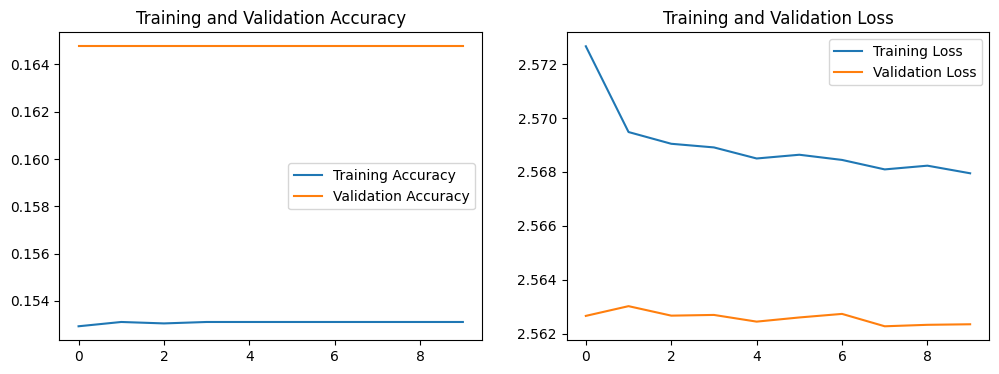

In [13]:
def plot_training_results(history):
    """Plot training and validation accuracy/loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Visualize results
plot_training_results(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step

Test image: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/63850dfe-2c79-4728-8557-b1eb242e16f1___YLCV_GCREC 2298.JPG
True class: Tomato__Tomato_YellowLeaf__Curl_Virus

Top 3 predictions:
1. Tomato__Tomato_YellowLeaf__Curl_Virus: 14.81%
2. Tomato_Bacterial_spot: 10.29%
3. Tomato_Late_blight: 9.47%


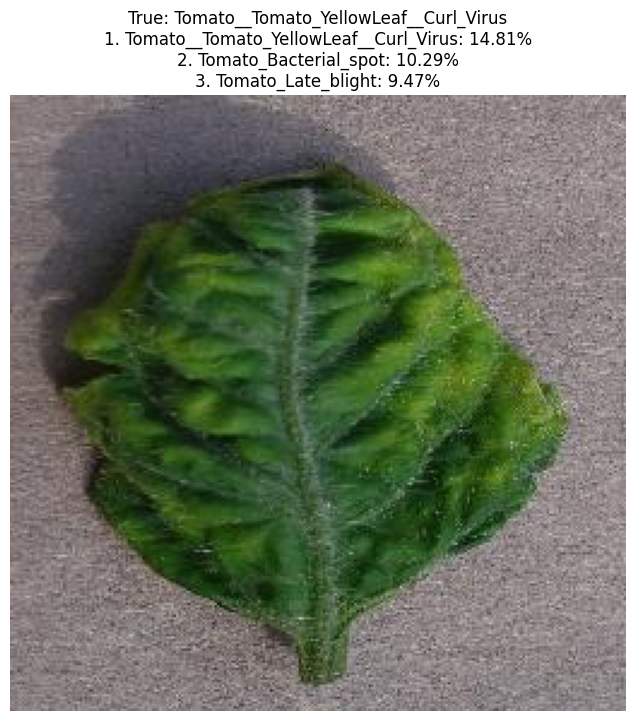

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random

data_dir = "PlantVillage" # for Colab

# Load the saved model instead of training
#model = tf.keras.models.load_model('plant_disease_model.h5')


def predict_disease(model, image_path, class_names):
    """Make prediction on a single image"""
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = predictions[0]

    # Get top 3 predictions
    top_3_idx = np.argsort(score)[-3:][::-1]
    results = []
    for idx in top_3_idx:
        results.append({
            "class": class_names[idx],
            "confidence": float(score[idx])
        })

    return results

# Function to get a random test image


def get_random_test_image(data_dir):
    # Get all class directories
    class_dirs = [d for d in os.listdir(
        data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Pick a random class
    random_class = random.choice(class_dirs)
    class_path = os.path.join(data_dir, random_class)

    # Get all images in that class
    images = [f for f in os.listdir(
        class_path) if f.casefold().endswith(('.jpg', '.jpeg', '.png'))]

    # Pick a random image
    random_image = random.choice(images)
    image_path = os.path.join(class_path, random_image)

    return image_path, random_class


# Get class names
class_names = sorted([item for item in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, item))])

# Get a random test image
test_image_path, true_class = get_random_test_image(data_dir)

# Make prediction
results = predict_disease(model, test_image_path, class_names)

# Print results
print(f"\nTest image: {test_image_path}")
print(f"True class: {true_class}")
print("\nTop 3 predictions:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['class']}: {result['confidence']*100:.2f}%")

# Display the image with top 3 predictions
img = mpimg.imread(test_image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(
    f"True: {true_class}\n1. {results[0]['class']}: {results[0]['confidence']*100:.2f}%\n2. {results[1]['class']}: {results[1]['confidence']*100:.2f}%\n3. {results[2]['class']}: {results[2]['confidence']*100:.2f}%")
plt.axis('off')
plt.show()


# Konklusion
Det viser sig at netværket egentlig ikke er særlig godt.
* Det kan være der er for få træningsdata (antal/variation/kvalitet).
* Learning rate er en vigtig parameter, der styrer, hvor hurtigt modellen lærer. Hvis learning rate er for høj, kan modellen "hoppe" over de optimale løsninger. Måske den skulle tweakes.
* Batch size er et andet vigtigt parameter, der bestemmer, hvor mange billeder modellen ser på ad gangen. En for stor batch size kan føre til dårligere generalisering, mens en for lille batch size kan gøre træningen ustabil.
* Netværket nok lidt for basic til opgaven.
Jeg har dog ikke trænet det mere end 10 epochs og det er for lidt. Men compute koster. Det ville måske give bedre resultater hvis man kørte den i 100 runder i stedet. Deep learning modeller har det med at konvergere bedre over lange trænings runder, da gradientberegningerne havner mere optimale steder, frem for at havne på et lokalt minimum.

**Så mere træningsdata og mere compute ville nok forbedre resultet markant.**

Man kunne gøre det i stedet at man tog en eksisterende model og fintunede med datasættet. Men så har man bare brugt nogle andres. Det ville dog være billigere i compute.
